# Predicción de Variables Oceanográficas con Aurora Preentrenado para HRES

Este notebook está diseñado como parte de mi trabajo de fin de grado sobre predicción de variables oceanográficas utilizando el modelo Aurora. Aquí se demuestra cómo reducir la resolución necesaria para trabajar con una GPU de 13 GiB y cómo realizar inferencia con Aurora preentrenado.

## Ejemplo: Predicciones para HRES a 0.1 grados

En este ejemplo, se descargarán datos de análisis HRES del sistema IFS con una resolución de 0.1 grados para el día 11 de mayo de 2022 desde el Research Data Archive. Luego, se ejecutará Aurora en estos datos utilizando la versión del modelo ajustada para análisis HRES del IFS a 0.1 grados de resolución.

## Instalación de dependencias

Primero, se deben instalar los paquetes de Python necesarios para ejecutar este notebook:

```bash
pip install requests xarray cfgrib scipy matplotlib


In [1]:

# Importación de librerías
from datetime import datetime
from pathlib import Path
import requests
import xarray as xr


## Descarga de datos

En esta sección, se descargan los datos necesarios desde el Research Data Archive.


In [2]:
# Defino la ruta de descarga.
download_path = Path("~/downloads/hres_0.1").expanduser()

# Especifico el día para descargar los datos (11 de mayo de 2022).
date = datetime(2022, 5, 11)

# Asigno los números asociados a cada variable para la solicitud de datos.
var_nums = {
    "2t": "167",  # Temperatura a 2 metros
    "10u": "165",  # Componente u del viento a 10 metros
    "10v": "166",  # Componente v del viento a 10 metros
    "msl": "151",  # Presión media a nivel del mar
    "t": "130",  # Temperatura (atmosférica)
    "u": "131",  # Componente u del viento (atmosférica)
    "v": "132",  # Componente v del viento (atmosférica)
    "q": "133",  # Humedad específica (atmosférica)
    "z": "129",  # Geopotencial
    "slt": "043",  # Tipo de suelo
    "lsm": "172",  # Máscara tierra-mar
}

# Creo las URLs para descargar los datos necesarios.
downloads: dict[Path, str] = {}
for v in ["2t", "10u", "10v", "msl", "z", "slt", "lsm"]:
    downloads[download_path / date.strftime(f"surf_{v}_%Y-%m-%d.grib")] = (
        f"https://data.rda.ucar.edu/ds113.1/"
        f"ec.oper.an.sfc/{date.year}{date.month:02d}/ec.oper.an.sfc.128_{var_nums[v]}_{v}."
        f"regn1280sc.{date.year}{date.month:02d}{date.day:02d}.grb"
    )
for v in ["z", "t", "u", "v", "q"]:
    for hour in [0, 6, 12, 18]:
        prefix = "uv" if v in {"u", "v"} else "sc"
        downloads[download_path / date.strftime(f"atmos_{v}_%Y-%m-%d_{hour:02d}.grib")] = (
            f"https://data.rda.ucar.edu/ds113.1/"
            f"ec.oper.an.pl/{date.year}{date.month:02d}/ec.oper.an.pl.128_{var_nums[v]}_{v}."
            f"regn1280{prefix}.{date.year}{date.month:02d}{date.day:02d}{hour:02d}.grb"
        )

# Descargo los datos y los almaceno en la carpeta especificada.
for target, source in downloads.items():
    if not target.exists():
        print(f"Descargando {source}")
        target.parent.mkdir(parents=True, exist_ok=True)
        response = requests.get(source)
        response.raise_for_status()
        with open(target, "wb") as f:
            f.write(response.content)
print("¡Descargas finalizadas!")


¡Descargas finalizadas!


## Preparación del lote de datos

En esta sección, los datos descargados se convierten en un lote (`aurora.Batch`), que es el formato requerido por el modelo.


In [3]:
import numpy as np
import torch
from aurora import Batch, Metadata

# Defino los niveles de presión a utilizar.
levels = (1000, 925, 850, 700, 600, 500, 400, 300, 250, 200, 150, 100, 50)

# Defino funciones para cargar variables de superficie y atmosféricas.
def load_surf(v: str, v_in_file: str) -> torch.Tensor:
    """Cargo variables de superficie o estáticas para las horas 00 y 06."""
    ds = xr.open_dataset(download_path / date.strftime(f"surf_{v}_%Y-%m-%d.grib"), engine="cfgrib")
    data = ds[v_in_file].values[:2]  # Uso las horas 00 y 06.
    data = data[None]  # Inserto una dimensión de lote.
    return torch.from_numpy(data)

def load_atmos(v: str) -> torch.Tensor:
    """Cargo variables atmosféricas para las horas 00 y 06."""
    ds_00 = xr.open_dataset(
        download_path / date.strftime(f"atmos_{v}_%Y-%m-%d_00.grib"), engine="cfgrib"
    )
    ds_06 = xr.open_dataset(
        download_path / date.strftime(f"atmos_{v}_%Y-%m-%d_06.grib"), engine="cfgrib"
    )
    ds_00 = ds_00[v].sel(isobaricInhPa=list(levels))
    ds_06 = ds_06[v].sel(isobaricInhPa=list(levels))
    data = np.stack((ds_00.values, ds_06.values), axis=0)
    data = data[None]  # Inserto una dimensión de lote.
    return torch.from_numpy(data)

# Extraigo latitudes y longitudes de un archivo descargado.
ds = xr.open_dataset(next(iter(downloads.keys())), engine="cfgrib")

batch = Batch(
    surf_vars={
        "2t": load_surf("2t", "t2m"),
        "10u": load_surf("10u", "u10"),
        "10v": load_surf("10v", "v10"),
        "msl": load_surf("msl", "msl"),
    },
    static_vars={
        "z": load_surf("z", "z")[0, 0],
        "slt": load_surf("slt", "slt")[0, 0],
        "lsm": load_surf("lsm", "lsm")[0, 0],
    },
    atmos_vars={
        "t": load_atmos("t"),
        "u": load_atmos("u"),
        "v": load_atmos("v"),
        "q": load_atmos("q"),
        "z": load_atmos("z"),
    },
    metadata=Metadata(
        lat=torch.from_numpy(ds.latitude.values),
        lon=torch.from_numpy(ds.longitude.values),
        time=(date.replace(hour=6),),
        atmos_levels=levels,
    ),
)


c:\Users\Victor\miniconda3\envs\Aurora_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Comprobación de la resolución original de los datos

En esta sección, se verifica la resolución original de los datos descargados para entender el tamaño de la grilla con la que se está trabajando.


In [4]:
#Con esto se comprueba la resolucion original de los datos 
xr.open_dataset(download_path / date.strftime(f"surf_{"2t"}_%Y-%m-%d.grib"), engine="cfgrib")

<xarray.Dataset> Size: 210MB
Dimensions:     (time: 4, latitude: 2560, longitude: 5120)
Coordinates:
    number      int32 4B ...
  * time        (time) datetime64[ns] 32B 2022-05-11 ... 2022-05-11T18:00:00
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
  * latitude    (latitude) float64 20kB 89.95 89.88 89.81 ... -89.88 -89.95
  * longitude   (longitude) float64 41kB 0.0 0.07031 0.1406 ... 359.9 359.9
    valid_time  (time) datetime64[ns] 32B ...
Data variables:
    t2m         (time, latitude, longitude) float32 210MB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-11-29T09:25 GRIB to CDM+CF via cfgrib-0.9.1...

**Resultado:**  
La resolución original de los datos es:
- Latitudes: 2560
- Longitudes: 5120
- Tiempo: 4

Esta resolución es extremadamente alta (0.1 grados), lo cual no es manejable con una GPU de 13 GiB. Se requiere reducir la resolución para poder procesar los datos.


## Reducción de la resolución (regrid a 0.1 grados)

En esta sección, los datos se reescalan a una resolución más baja (0.1 grados) utilizando la función de `regrid` de Aurora.


In [5]:
batch = batch.regrid(res=0.1)

In [6]:
#comprobar la resolucion dps del regrid
batch.surf_vars["2t"].shape

torch.Size([1, 2, 1801, 3600])

**Resultado:**  
Después del reescalado, las dimensiones de los datos son:
- [1, 2, 1801, 3600]

Aunque la resolución se ha reducido, todavía es alta para la GPU. Es necesario realizar una interpolación adicional para manejar los datos eficientemente.


## Interpolación a 0.5 grados

La resolución se reduce aún más a 0.5 grados, lo que permite que los datos sean manejables con la GPU disponible.


In [7]:
batch = batch.regrid(res=0.5)

In [8]:
#comprobar la resolucion dps del regrid
batch.surf_vars["2t"].shape

torch.Size([1, 2, 361, 720])

**Resultado:**  
Con la nueva interpolación, las dimensiones son:
- [1, 2, 361, 720]

Ahora los datos tienen una resolución adecuada para la GPU de 13 GiB.


## Carga y ejecución del modelo

En esta sección, se carga el modelo preentrenado Aurora y se realizan predicciones utilizando los datos preparados.


In [9]:
from aurora import AuroraHighRes, rollout

# Cargar el modelo preentrenado Aurora
model = AuroraHighRes()
model.load_checkpoint("microsoft/aurora", "aurora-0.1-finetuned.ckpt")

# Configuración del modelo para inferencia
model.eval()
model = model.to("cuda")

# Realizar predicciones para dos pasos de tiempo
with torch.inference_mode():
    preds = [pred.to("cpu") for pred in rollout(model, batch, steps=2)]

# Regresar el modelo a CPU después de la inferencia
model = model.to("cpu")


c:\Users\Victor\miniconda3\envs\Aurora_env\Lib\site-packages\aurora\model\perceiver.py:136: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  out = F.scaled_dot_product_attention(q, k, v)


**Comentario:**  
El modelo realiza predicciones para dos pasos temporales:
1. Hora **12:00**  
2. Hora **18:00**  

Esto genera las temperaturas pronosticadas para estas horas en base a los datos reescalados.


## Visualización de las predicciones

En esta sección, se comparan las predicciones del modelo con los datos reales de análisis HRES.


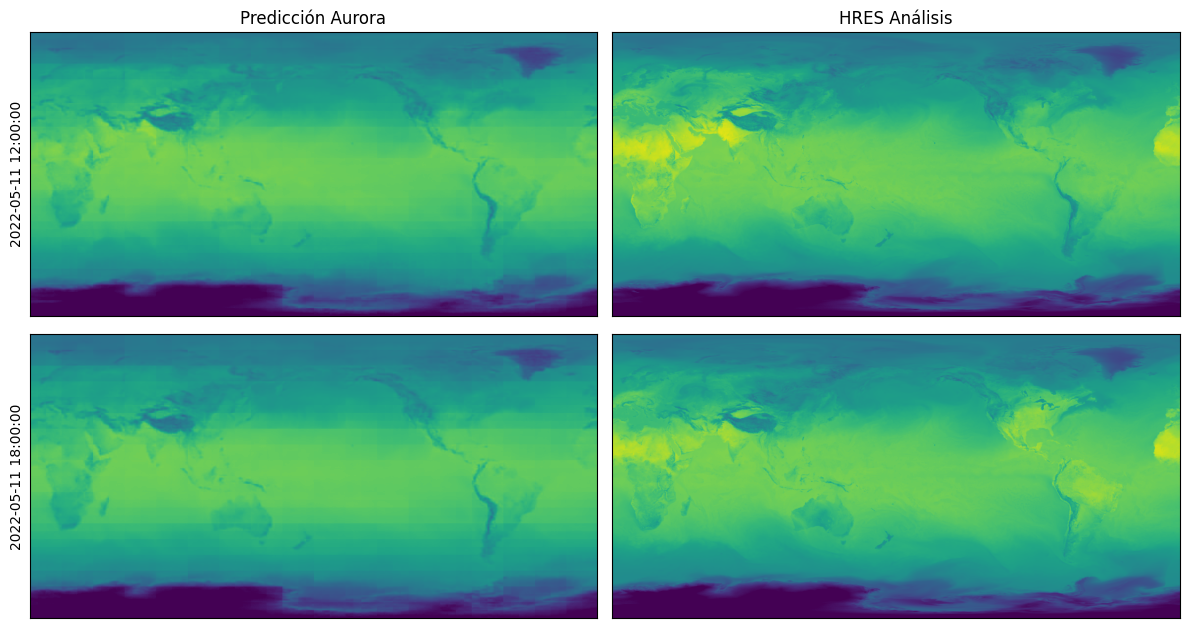

In [ ]:
import matplotlib.pyplot as plt

# Cargar los datos reales para comparación
truth = xr.open_dataset(download_path / date.strftime("surf_2t_%Y-%m-%d.grib"), engine="cfgrib")

# Visualizar las predicciones y los datos reales
fig, ax = plt.subplots(2, 2, figsize=(12, 6.5))

for i in range(ax.shape[0]):
    pred = preds[i]

    # Predicciones de Aurora
    ax[i, 0].imshow(pred.surf_vars["2t"][0, 0].numpy() - 273.15, vmin=-50, vmax=50)
    ax[i, 0].set_ylabel(str(pred.metadata.time[0]))
    if i == 0:
        ax[i, 0].set_title("Predicción Aurora")
    ax[i, 0].set_xticks([])
    ax[i, 0].set_yticks([])

    # Datos reales de análisis HRES
    ref = truth["t2m"][2 + i].values
    ax[i, 1].imshow(ref - 273.15, vmin=-50, vmax=50)
    if i == 0:
        ax[i, 1].set_title("HRES Análisis")
    ax[i, 1].set_xticks([])
    ax[i, 1].set_yticks([])

plt.tight_layout()


**Resultado:**  
El gráfico muestra:
1. Predicciones del modelo Aurora en un rango de temperaturas (-50°C a 50°C).  
2. Datos reales del análisis HRES para las mismas horas.  

Esto permite evaluar visualmente la precisión del modelo Aurora frente a los datos reales.


## Evaluación de las predicciones

Se extraen estadísticas clave de las temperaturas predichas para analizar su rango y valores promedio.


In [11]:
# Estadísticas de las predicciones
pred_mean = preds[0].surf_vars['2t'].mean()
pred_min = preds[0].surf_vars['2t'].min()
pred_max = preds[0].surf_vars['2t'].max()

print(f"Temperatura media: {pred_mean.item():.2f} K")
print(f"Temperatura mínima: {pred_min.item():.2f} K")
print(f"Temperatura máxima: {pred_max.item():.2f} K")


Temperatura media: 278.61 K
Temperatura mínima: 205.36 K
Temperatura máxima: 307.32 K


**Resultados:**  
- **Temperatura media:** 278.61 K (≈ 5.46°C)  
- **Temperatura mínima:** 205.36 K (≈ -67.79°C)  
- **Temperatura máxima:** 307.32 K (≈ 34.17°C)  

Estos valores son consistentes con los rangos esperados para análisis atmosféricos globales.


## Conclusión

El modelo Aurora preentrenado para HRES es capaz de realizar inferencias precisas sobre datos de análisis atmosférico. Sin embargo, para usar una GPU de 13 GiB, fue necesario reducir significativamente la resolución original (de 0.1 grados a 0.5 grados). Esta interpolación permite procesar los datos sin comprometer demasiado la precisión de las predicciones.  

Este método puede incorporarse directamente a la configuración experimental del trabajo de fin de grado.
